In [1]:
import os
from PIL import Image, ImageFile
import math
import copy
import wandb
ImageFile.LOAD_TRUNCATED_IMAGES = True
import matplotlib.pyplot as plt # for plotting
import numpy as np # for transformation

import torch # PyTorch package
import torchvision # load datasets
import torchvision.transforms as transforms # transform data
from torch.autograd import Variable
import torch.cuda as cuda
import torch.nn as nn # basic building block for neural neteorks
import torch.nn.functional as F # import convolution functions like Relu
import torch.optim as optim # optimzer
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from utils import *


In [2]:
def checkImage(path):
    try:
        im = Image.open(path)
        return True
    except:
        return False
    pass

img_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    ])

non_augmentned = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    ])

gray = transforms.Compose([
    transforms.Grayscale()
    ])

augmentations = {
    'rotation': transforms.Compose([transforms.RandomRotation(degrees=(0,90))]),
    'rotation2': transforms.Compose([transforms.RandomRotation(degrees=(270,360))]),
    'norm': transforms.Compose([transforms.Normalize(mean=[0.42, 0.42, 0.42],std=[0.42, 0.42, 0.42] )]),
    'affine': transforms.Compose([ transforms.RandomAffine(degrees=(0, 90), scale=(0.5, 0.9))]),
    'affine2': transforms.Compose([ transforms.RandomAffine(degrees=(270, 360), scale=(0.5, 0.9))]),
    'blur': transforms.Compose([transforms.GaussianBlur(kernel_size=(3, 7), sigma=(0.1, 3))]),
    'sharpness': transforms.Compose([transforms.RandomAdjustSharpness(40)]),
    'contrast': transforms.Compose([transforms.ColorJitter(contrast=(1,2))]),
}


def imshow(img):
  ''' function to show image '''
  #img = img / 2 + 0.5 # unnormalize
  npimg = img.numpy() # convert to numpy objects
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()


In [3]:
base_dir = './dataset/'
print(os.listdir(base_dir))
for base in os.listdir(base_dir):
    if base == "train":
        train_datasets = []
        for augmentation_name, augmentation_transform in augmentations.items():
            combined_transform = transforms.Compose([img_transforms,augmentation_transform])
            dataset = torchvision.datasets.ImageFolder(
                root=os.path.join(base_dir, base),
                transform=combined_transform,  # Combine main and augmentation transforms
                is_valid_file=checkImage
            )
            train_datasets.append(dataset)

        new_train = torch.utils.data.ConcatDataset(train_datasets)
        
        
    elif base == "val":
        val_datasets = []
        for augmentation_name, augmentation_transform in augmentations.items():
            combined_transform = transforms.Compose([img_transforms,augmentation_transform])
            print(combined_transform)
            dataset = torchvision.datasets.ImageFolder(
                root=os.path.join(base_dir, base),
                transform=combined_transform,  # Combine main and augmentation transforms
                is_valid_file=checkImage
            )
            val_datasets.append(dataset)

        new_val = torch.utils.data.ConcatDataset(val_datasets)
    elif base == "test":
        test_data = torchvision.datasets.ImageFolder(root = os.path.join(base_dir,base), transform = non_augmentned, is_valid_file = checkImage)
        new_test = test_data


['.DS_Store', 'test', 'train', 'val']
Compose(
    Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)
    Compose(
    RandomRotation(degrees=[0.0, 90.0], interpolation=nearest, expand=False, fill=0)
)
)
Compose(
    Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)
    Compose(
    RandomRotation(degrees=[270.0, 360.0], interpolation=nearest, expand=False, fill=0)
)
)
Compose(
    Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)
    Compose(
    Normalize(mean=[0.42, 0.42, 0.42], std=[0.42, 0.42, 0.42])
)
)
Compose(
    Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)
    Compose(
    RandomAffine(degrees=[0.0, 90.0], scale=(0.5, 0.9))
)
)
Compose(
    Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTen

In [4]:
#By default, PyTorch’s data loaders are set to a batch_size of 1.
BATCH_SIZE = 200
train_data_loader = torch.utils.data.DataLoader(new_train, batch_size = BATCH_SIZE,shuffle=True, num_workers=2)
val_data_loader  = torch.utils.data.DataLoader(new_val, batch_size = BATCH_SIZE,shuffle=True, num_workers=2) 
test_data_loader  = torch.utils.data.DataLoader(new_test, batch_size = 128,shuffle=False, num_workers=2)


num_step =math.ceil(len(train_data_loader.dataset) / BATCH_SIZE)

print(type(train_data_loader))


<class 'torch.utils.data.dataloader.DataLoader'>


In [ ]:
classes = ('scgc','scgp','wedo')

sample = next(iter(train_data_loader))
imgs, lbls = sample
print(lbls)
print(imgs.shape)

# call function on our images # +29
# imshow(torchvision.utils.make_grid(imgs[30],nrow=15,padding=20))
# imshow(torchvision.utils.make_grid(imgs[83],nrow=15,padding=20))
# imshow(torchvision.utils.make_grid(imgs[136],nrow=15,padding=20))
# imshow(torchvision.utils.make_grid(imgs[189],nrow=15,padding=20))
# imshow(torchvision.utils.make_grid(imgs[239],nrow=15,padding=20))
# imshow(torchvision.utils.make_grid(imgs[293],nrow=15,padding=20))
# imshow(torchvision.utils.make_grid(imgs[347],nrow=15,padding=20))
# imshow(torchvision.utils.make_grid(imgs[401],nrow=15,padding=20))
imshow(torchvision.utils.make_grid(imgs,nrow=15,padding=20))
print(' '.join('%s' % classes[lbls[j]] for j in range(len(imgs))))


In [5]:
from model import *
from torchsummary import summary
net = ResNet(ResidualBlock, [3, 4, 6, 3],num_classes=3)
summary(net, (3, 224, 224))
print(net)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,472
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,160
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,928
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,640
      BatchNorm2d-12          [-1, 256, 56, 56]             512
             ReLU-13          [-1, 256, 56, 56]               0
           Conv2d-14          [-1, 256,

In [ ]:
 #wand setup
#"weightname":"S12_3-9_fir8-14"
#name=f"CNN_S12_3-9_fir8-14",
wandb.login()
wand = wandb.init(
      # Set the project where this run will be logged
      project="AR-classification", 
      # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
      name=f"res50_AR_12", 
      # Track hyperparameters and run metadata
      # 0.0000001
      config={
      "learning_rate": 0.0001,
      "architecture": "CNN",
      "dataset": "Organization",
      "epochs": 200,
      "weightname":"res50_12",
      "num_step_per_epoch" : num_step
      }
    )

In [ ]:
config = wand.config
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=config.learning_rate, weight_decay = 0.001, momentum = 0.9)


In [ ]:
train_loss,valid_loss,train_accuracy,valid_accuracy =train(
    model = net,
    loader_train = train_data_loader,
    loader_test =test_data_loader,
    vail_loader = val_data_loader,
    optimizer = optimizer  ,
    criterion = criterion ,
    device = 'cuda',
    wand = wand
)


wandb.alert(
            title='Finish',
            text=f'Finishing training',
        )

In [6]:
PATH = f"./save_weight/res50_12/0.3732_res50_12_0.3732_82.7586.pth"
# # reload
net = ResNet(ResidualBlock, [3, 4, 6, 3])
net.load_state_dict(torch.load(PATH))


<All keys matched successfully>

<class 'torch.Tensor'>


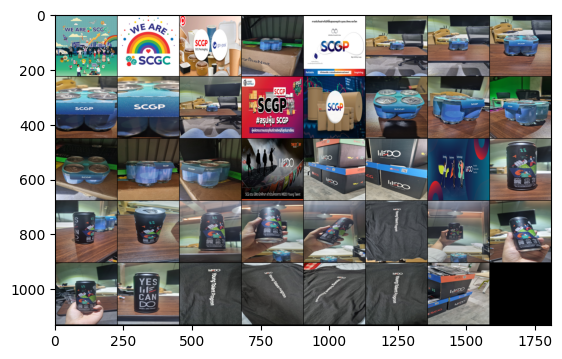

GroundTruth:  scgc scgc scgp scgp scgp scgp scgp scgp scgp scgp scgp scgp scgp scgp scgp scgp scgp scgp scgp wedo wedo wedo wedo wedo wedo wedo wedo wedo wedo wedo wedo wedo wedo wedo wedo wedo wedo wedo wedo
Predicted:  scgc scgc scgc scgp scgp scgp scgp scgp scgp scgc scgp wedo scgp scgp scgp scgp scgp scgp scgp wedo wedo wedo scgc wedo scgp scgp wedo scgp wedo wedo scgp scgp scgp wedo wedo wedo wedo wedo scgc


In [9]:
classes = ('scgc','scgp','wedo')
sample = next(iter(test_data_loader))
imgs, lbls = sample
print(type(imgs))
# print images
imshow(torchvision.utils.make_grid(imgs))
print('GroundTruth: ', ' '.join('%s' % classes[lbls[j]] for j in  range(len(imgs))))

outputs = net(imgs)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%s' % classes[predicted[j]]
                              for j in range(len(imgs))))

wrong_img = []
for i in range(len(imgs)):
    if classes[lbls[i]] != classes[predicted[i]]:
        wrong_img.append(imgs[i])


11


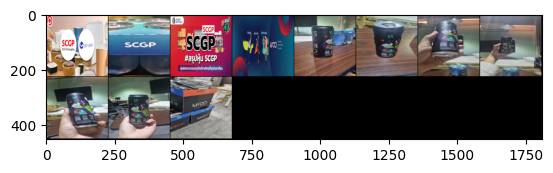

In [12]:
print(len(wrong_img))
imshow(torchvision.utils.make_grid(wrong_img))

tensor([0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])
tensor([0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 0, 2,
        1, 1, 2, 1, 2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 0])
39
28


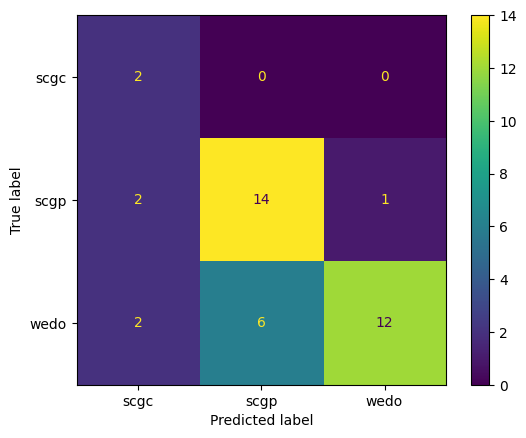

Accuracy of the network on the test images: 71 %


In [8]:
from sklearn import metrics
correct = 0
total = 0
with torch.no_grad():
    for data in test_data_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        print(labels)
        print(predicted)
        
        print(total)
        print(correct)

confusion_matrix = metrics.confusion_matrix(labels, predicted)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['scgc','scgp','wedo'])

cm_display.plot()
plt.show()
print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))